Average of Each playlist, represent then word cloud plots

In [1]:
import pandas as pd
import sqlalchemy as sa
from sqlalchemy.dialects.postgresql import JSON, JSONB
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker
import json
import csv
import datetime
from dateutil.parser import parser
import os
from pprint import pprint
from pathlib import Path
import glob
#from odo import odo
import importlib
import itertools
import sklearn.cluster
import pandas as pd
import numpy as np
import math
import operator
import sklearn
import matplotlib.pyplot as plt
import os, io, nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords 
import collections
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer

#importlib.invalidate_caches()
%load_ext autoreload
%autoreload 2

In [2]:
audio_features = pd.read_pickle('../Pickle_Files/audio_features.pkl')
track_elems = pd.read_pickle('../Pickle_Files/track_elems.pkl')
playlists = pd.read_pickle('../Pickle_Files/playlists.pkl')

In [3]:
join1 = pd.merge(audio_features,track_elems,on='track_uri')

In [4]:
join2 = pd.merge(join1,playlists[['name','pid']])

In [5]:
join2.columns

Index(['acousticness', 'danceability', 'energy', 'instrumentalness', 'key',
       'liveness', 'loudness', 'mode', 'speechiness', 'tempo',
       'time_signature', 'track_uri', 'valence', 'pid', 'pos', 'COUNT(*)',
       'name'],
      dtype='object')

In [6]:
group = {'acousticness':'mean', 'danceability':'mean', 'energy':'mean', 'instrumentalness':'mean', 'key':'mean',
       'liveness':'mean', 'loudness':'mean', 'speechiness':'mean', 'tempo':'mean', 'valence':'mean','name':'first'}
cols = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'key',
       'liveness', 'loudness', 'speechiness', 'tempo', 'valence','name']
average_playlist = join2.groupby('pid', as_index=True).aggregate(group).reindex(columns=cols)

In [7]:
average_playlist.head(5)

acousticness  danceability    energy  instrumentalness       key  \
pid                                                                     
0        0.082981      0.659212  0.782269          0.000676  5.038462   
1        0.164050      0.494715  0.690128          0.224431  4.461538   
2        0.269230      0.671875  0.693203          0.000638  5.000000   
3        0.273823      0.513571  0.621242          0.202002  5.103175   
4        0.177148      0.576765  0.650535          0.081875  3.352941   

     liveness  loudness  speechiness       tempo   valence              name  
pid                                                                           
0    0.191138 -4.878481     0.107188  123.007538  0.642615        Throwbacks  
1    0.185708 -8.288436     0.089085  124.907615  0.475487  Awesome Playlist  
2    0.169028 -4.874156     0.096288  114.600672  0.565078           korean   
3    0.188798 -9.614833     0.067201  125.039063  0.451893               mat  
4    0.166524 -7.634471     0.041159  127.759882  0.490765               90s

## K-Means Clustering

In [8]:
data = average_playlist.drop(['name'],axis=1)

In [9]:
# Convert DataFrame to matrix
mat = data.values
# Using sklearn
km = sklearn.cluster.KMeans(n_clusters=12)
km.fit(mat)
# Get cluster assignment labels
labels = km.labels_
# Format results as a DataFrame
average_playlist_cluster = pd.DataFrame(data=labels, columns=['cluster'], index=data.index)

In [10]:
average_playlist_cluster.head(5)

cluster
pid         
0          3
1          3
2         11
3         10
4          1

In [11]:
average_playlist_cluster = average_playlist_cluster.reset_index()

In [12]:
average_playlist_cluster.rename(columns={'index': 'pid'}, inplace=True)

In [13]:
playlists_clustered = pd.merge(average_playlist_cluster,playlists,on='pid')

In [14]:
playlists_clustered = playlists_clustered[['pid','name','cluster','num_followers','duration_ms','num_tracks','num_albums','num_artists','num_edits']]

In [15]:
playlists_clustered.head(5)

pid              name  cluster  num_followers  duration_ms  num_tracks  \
0    0        Throwbacks        3              1     11532414          52   
1    1  Awesome Playlist        3              1     11656470          39   
2    2           korean        11              1     14039958          64   
3    3               mat       10              1     28926058         126   
4    4               90s        1              2      4335282          17   

   num_albums  num_artists  num_edits  
0          47           37          6  
1          23           21          5  
2          51           31         18  
3         107           86          4  
4          16           16          7

#### Number of playlists in each cluster

In [16]:
playlists_clustered['cluster'].value_counts()

7     188327
3     174917
1     137758
11    133833
0      87163
9      73996
10     72709
4      63313
2      26792
5      19497
6      13922
8       7773
Name: cluster, dtype: int64

## PCA Visualization of Clusters

In [17]:
PCA_playlists = average_playlist.drop(['name'],axis=1)

In [18]:
PCA_playlists = pd.merge(PCA_playlists,average_playlist_cluster,on='pid')

#### Normalizing

In [19]:
from sklearn.preprocessing import StandardScaler
features = ['acousticness', 'danceability', 'energy','instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']
# Separating out the features
x = PCA_playlists.loc[:, features].values
# Separating out the target
# Standardizing the features
x = StandardScaler().fit_transform(x)

In [20]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [21]:
cluster_audio_playlists_PCA = PCA_playlists.reset_index()

In [22]:
cluster_audio_playlists_PCA = cluster_audio_playlists_PCA[['pid','cluster']]

In [23]:
finalDf = principalDf.join(cluster_audio_playlists_PCA, how='outer')

In [24]:
finalDf['cluster'] = finalDf['cluster'].apply(str)

In [25]:
finalDf['cluster'].value_counts()

7     188327
3     174917
1     137758
11    133833
0      87163
9      73996
10     72709
4      63313
2      26792
5      19497
6      13922
8       7773
Name: cluster, dtype: int64

## PCA Representation of All Songs Using Clusters

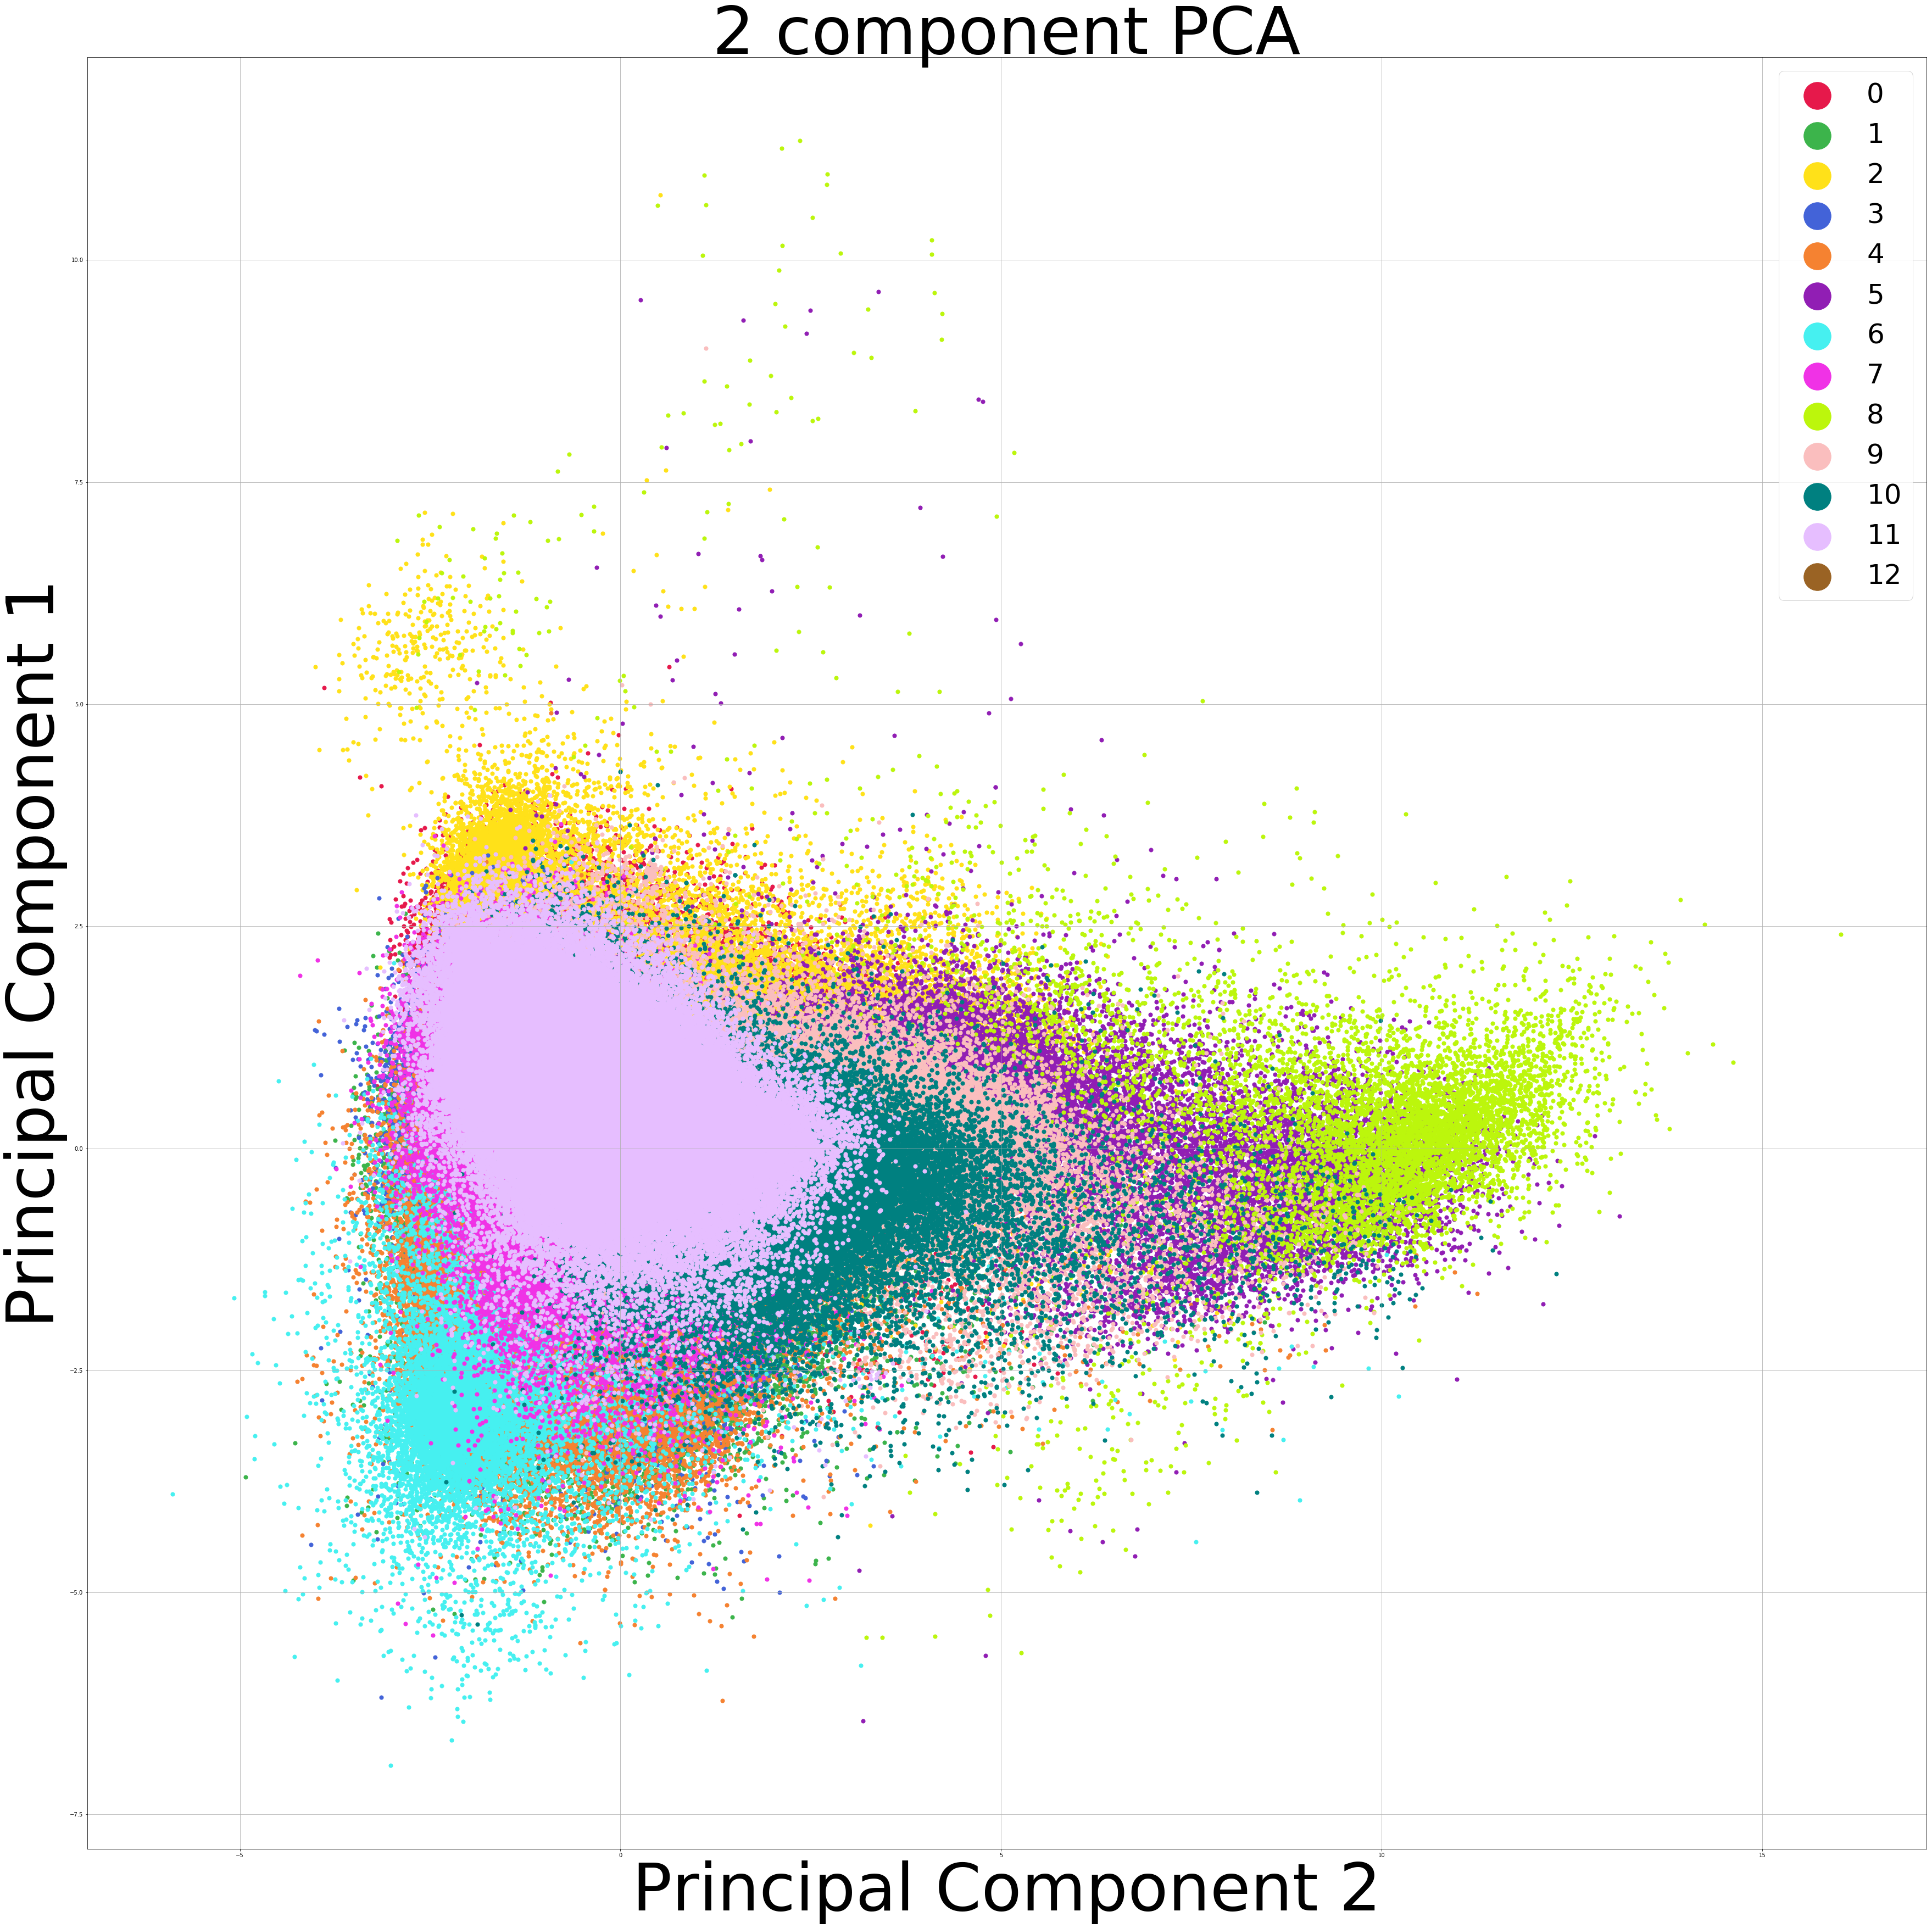

In [26]:
fig = plt.figure(figsize = (60,60))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 2', fontsize = 120)
ax.set_ylabel('Principal Component 1', fontsize = 120)
ax.set_title('2 component PCA', fontsize = 120)
targets = ['0','1','2','3','4','5','6','7','8','9','10','11','12']
colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['cluster'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets, prop={'size': 50},markerscale=7)
ax.grid()

## Choose the Clusters you would like to Compare and run the below code

In [27]:
import ipywidgets as widgets
from ipywidgets import Layout

style = {'description_width': 'initial'}

choose_clusters = widgets.Dropdown(
    options=[0,1,2,3,4,5,6,7,8,9,10,11],
    value=8,
    description='First Cluster:',
    layout=Layout(width='30%', height='50px',left='10px'),
    disabled=False,
)
display(choose_clusters)

choose_clusters2 = widgets.Dropdown(
    options=[0,1,2,3,4,5,6,7,8,9,10,11],
    value=11,
    description='Second Cluster:',style=style,
    layout=Layout(width='31.4%', height='50px',top='0px',left='-4px'),
    disabled=False,
)
display(choose_clusters2)

Dropdown(description='First Cluster:', index=8, layout=Layout(height='50px', left='10px', width='30%'), option…

Dropdown(description='Second Cluster:', index=5, layout=Layout(height='50px', left='-4px', top='0px', width='3…

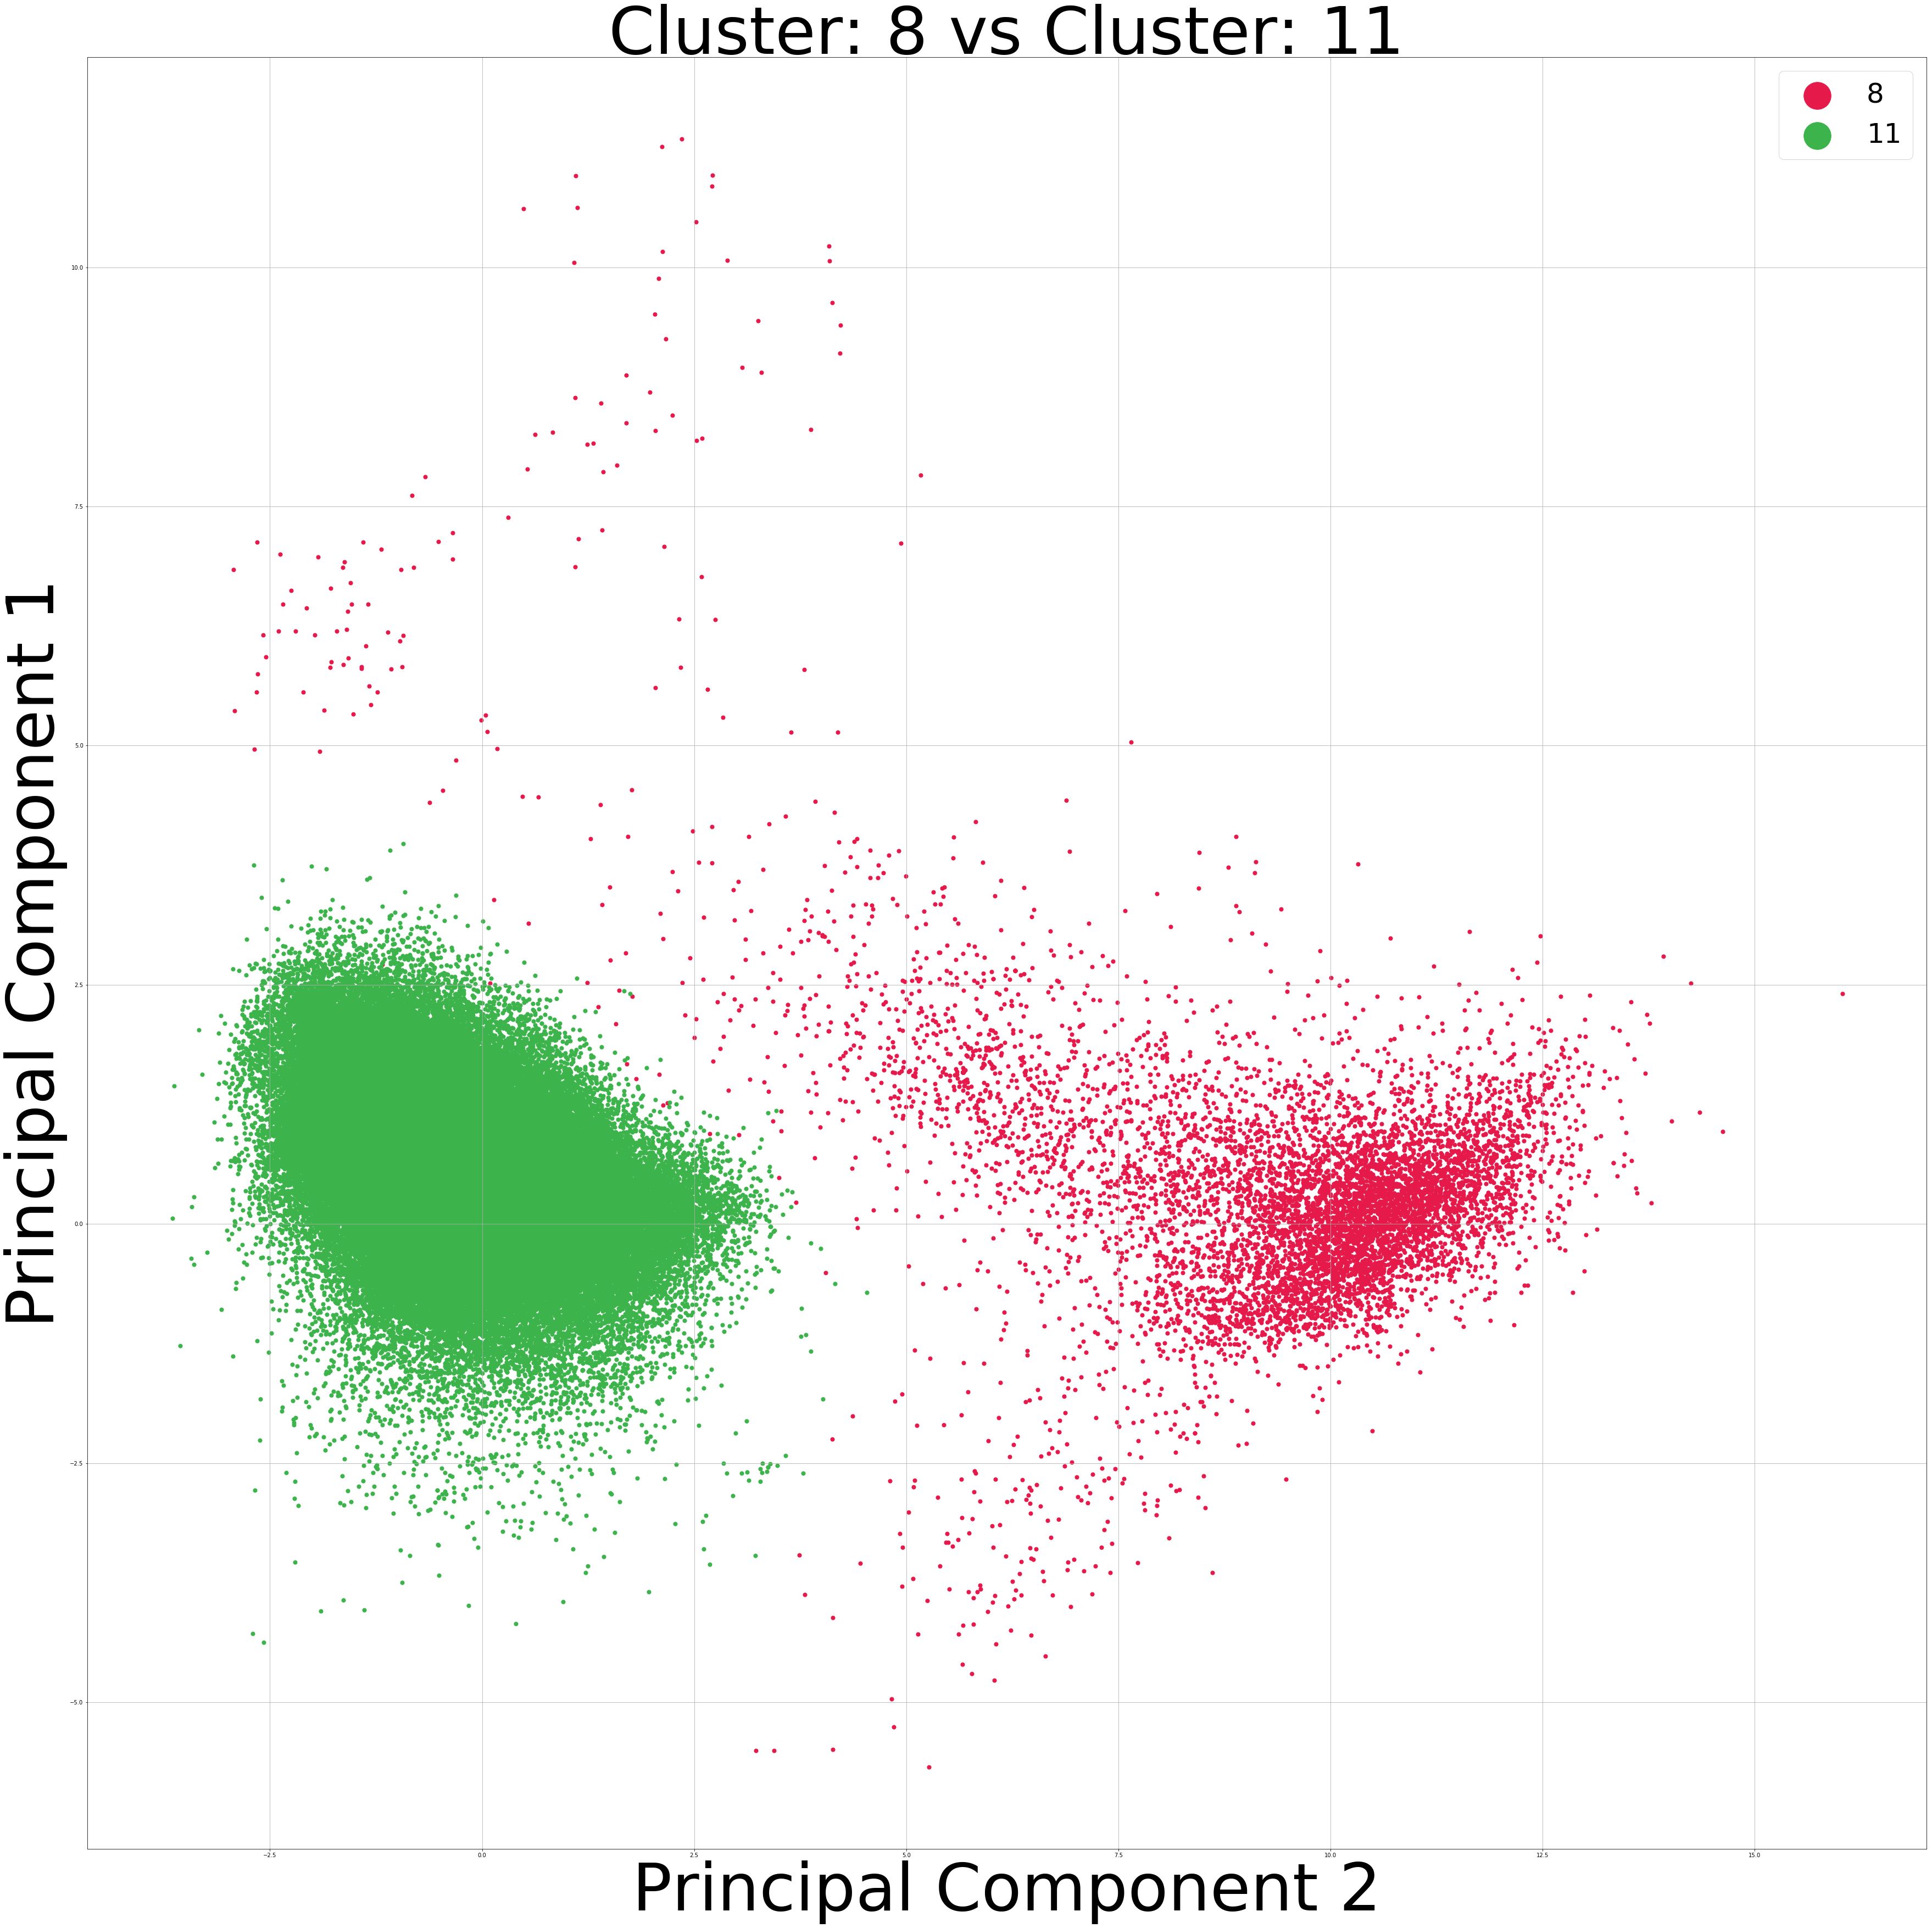

In [40]:
fig = plt.figure(figsize = (60,60))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 2', fontsize = 120)
ax.set_ylabel('Principal Component 1', fontsize = 120)
ax.set_title(str('Cluster: ' + str(choose_clusters.value) + ' vs Cluster: ' + str(choose_clusters2.value)), fontsize = 120)
targets = [''+str(choose_clusters.value)+'',''+str(choose_clusters2.value)+'']
colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['cluster'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets, prop={'size': 50},markerscale=7)
ax.grid()

## Word Clouds

In [29]:
def tokenize(series):
    
    TOKENIZER_REGEX = r'\w+'
    tokenizer = nltk.tokenize.RegexpTokenizer(TOKENIZER_REGEX)  
    return tokenizer.tokenize(series)

In [30]:
playlists_clustered['name'] = playlists_clustered.name.str.lower() 

In [31]:
playlists_clustered['name_tokenized'] = playlists_clustered['name'].apply(tokenize)

#### Most Popular Playlist Names

In [32]:
playlists_clustered['name'].value_counts().head(10)

chill        9256
country      8724
rap          8045
workout      7644
oldies       7413
christmas    6594
rock         6351
party        5487
throwback    5141
worship      4603
Name: name, dtype: int64

#### Most Popular Words in Playlists

In [33]:
stopwords_new = ["Music","music","Feat","feat","ft","FT","Vol","vol","Song","song","Single","single","The","the", 
"Of","of","And","and","To","to",'From','from','For','for','Sound','sound','For you','EP','ep','In','in','it','It'
'de','De','Me','My','On','All','Your','You','you','Songs','songs','La','la','No','no','Best','Hit','Time','El','New'
'Hits']

In [34]:
from wordcloud import WordCloud, STOPWORDS

In [35]:
stopwords = set(STOPWORDS)
stopwords.add("songs")
stopwords.add("New")
stopwords.add("Playlist")
stopwords.add("music")

## Pick Cluster for Word Cloud

In [36]:
import ipywidgets as widgets
from ipywidgets import Layout

style = {'description_width': 'initial'}

choose_clusters = widgets.Dropdown(
    options=[0,1,2,3,4,5,6,7,8,9,10,11],
    value=8,
    description='Cluster:',
    layout=Layout(width='30%', height='50px',left='10px'),
    disabled=False,
)
display(choose_clusters)

Dropdown(description='Cluster:', index=7, layout=Layout(height='50px', left='10px', width='30%'), options=(0, …

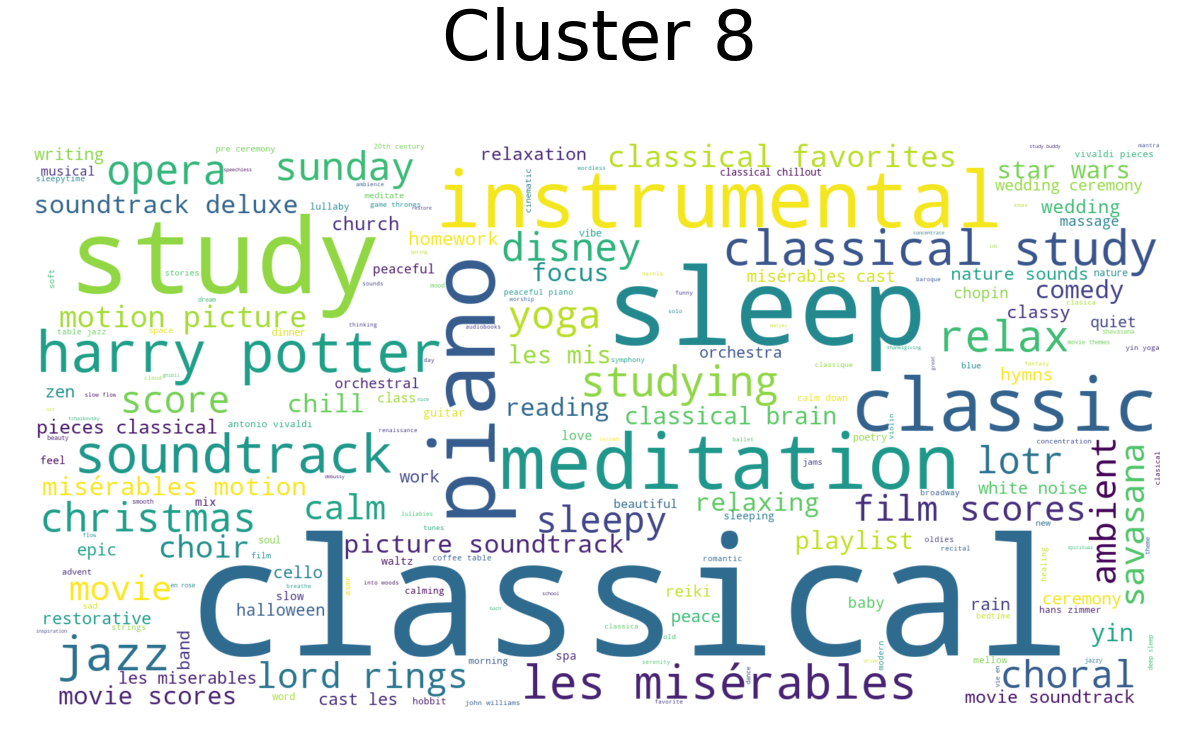

In [39]:
cluster = playlists_clustered[playlists_clustered['cluster'] == choose_clusters.value]

combine = cluster['name_tokenized'].values.tolist()
combined = sum(combine, [])

joined_list = (' ').join(combined) 
    
wordcloud_plot = WordCloud(stopwords=stopwords_new,width=1600, height=800,max_words=200, background_color='white').generate(joined_list)
plt.figure( figsize=(20,10),facecolor= None)
plt.title(str('Cluster '+str(choose_clusters.value)+'\n'),fontsize=70)
plt.imshow(wordcloud_plot, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()